In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib.ticker import IndexLocator
import time, sys
import pickle

In [2]:
# Given parameters
nx = 60
ny = 60
tf = 5.0
dt = 1.0e-2
nt = int(tf/dt)
xmin = 0; xmax = 1
ymin = 0; ymax = 1
dims=(nx,ny)

# POD basis
num_basis=np.arange(3,7,1)
print('num_basis {}'.format(num_basis))

# parameters
p_inter=5
FOM_parameters = np.arange(75,125+1,1,dtype=int)
print("Prediction Parameters: {}".format(FOM_parameters))
print("training parameters={}".format(FOM_parameters[p_inter:-p_inter:p_inter]))

# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

# file path
file_path_gappy_DEIM_result = "./wave_result/ex23_POD_bndry_DEIM_gappy_result.p"
file_name_SVD="./wave_model/ex23_SVD.p"

# full, inner, bc index
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
x0_multi_index=(multi_index_j[:,0].flatten(),multi_index_i[:,0].flatten())
x1_multi_index=(multi_index_j[:,-1].flatten(),multi_index_i[:,-1].flatten())
y0_multi_index=(multi_index_j[0,:].flatten(),multi_index_i[0,:].flatten())
y1_multi_index=(multi_index_j[-1,:].flatten(),multi_index_i[-1,:].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
bc_raveled_indicies=np.unique(np.concatenate((x0_raveled_indicies,x1_raveled_indicies,
                                              y0_raveled_indicies,y1_raveled_indicies)))
inner_raveled_indicies=np.setdiff1d(full_raveled_indicies,bc_raveled_indicies)

num_basis [3 4 5 6]
Prediction Parameters: [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
training parameters=[ 80  85  90  95 100 105 110 115 120]


# gappyPOD

In [3]:
# Jessi 알고리즘
def DEIM(phi_f, nfeval, unseen=np.array([])):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    
    l=0
    u=np.reshape(phi_f[:,l],(n,1))
    r=np.abs(u)
    if len(unseen) >0 :
        r[unseen]=ninf
    p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
    p=p_temp
    U=u
    
    ns=int(np.ceil((nfeval-1)/(m-1)))
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        for k in range(ns):
            if len(p)==nfeval:
                return p
            c=np.linalg.lstsq(U[p,:],u[p,:],rcond=None)[0]
            r=np.abs(u-U@c)
            r[p]=ninf
            if len(unseen) > 0:
                r[unseen]=ninf
            p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
            p=np.sort(np.append(p,p_temp))
        U=np.concatenate((U,u),axis=1)
         
    return p

# of measurments: 12
[   0    1   58   59   60  119 3480 3539 3540 3541 3598 3599]
# of measurments: 12
[   0   58   59   60 1799 1859 3480 3539 3540 3569 3598 3599]
# of measurments: 12
[   0   30   58   59   60 1739 1799 1800 3540 3569 3598 3599]
# of measurments: 12
[   0   30   58   59   60 1739 1799 1800 3540 3569 3598 3599]


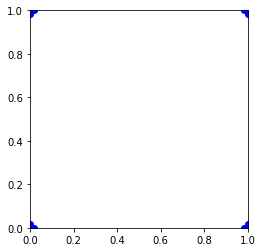

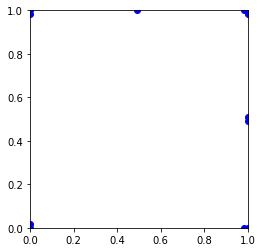

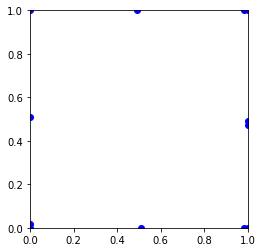

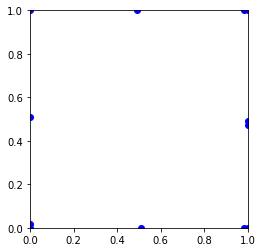

In [4]:
with open(file=file_name_SVD, mode='rb') as ff:  
    SVD = pickle.load(ff)

for ii in range(len(num_basis)):
    POD_basis=num_basis[ii]
    
    # DEIM
    num_msmt=12

    phi_DEIM=SVD['U'][:,:POD_basis]

    msmt_idx=DEIM(phi_DEIM,num_msmt,inner_raveled_indicies)
    msmt_idx.sort()

    print("# of measurments: {}".format(len(msmt_idx)))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(x[msmt_idx],y[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
    plt.savefig("./wave_result/ex23_POD_{}_bndry_DEIM_{}_samples.png".format(POD_basis,num_msmt))

# of POD basis is 3
# of measurments: 12
[   0    1   58   59   60  119 3480 3539 3540 3541 3598 3599]


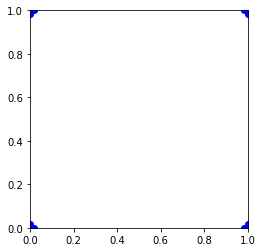

Param is 75
Time elapsed: 2.156973361968994 sec
average relative error of u: 6.634969343244068%
maximum relative error of u: 8.541134527941416%

Param is 76
Time elapsed: 2.018420696258545 sec
average relative error of u: 6.2426838284358395%
maximum relative error of u: 8.174632368093402%

Param is 77
Time elapsed: 1.4394760131835938 sec
average relative error of u: 5.878778894720549%
maximum relative error of u: 7.828846203567254%

Param is 78
Time elapsed: 1.1506602764129639 sec
average relative error of u: 5.551848242424677%
maximum relative error of u: 7.519649810437372%

Param is 79
Time elapsed: 1.1045515537261963 sec
average relative error of u: 5.2718106739413075%
maximum relative error of u: 7.240143954016756%

Param is 80
Time elapsed: 0.981792688369751 sec
average relative error of u: 5.049658567570205%
maximum relative error of u: 6.9945055425122495%

Param is 81
Time elapsed: 3.0527660846710205 sec
average relative error of u: 4.896334030571657%
maximum relative error of u

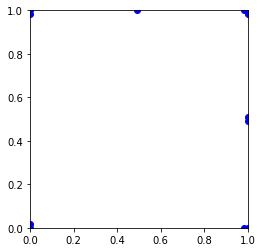

Param is 75
Time elapsed: 1.6581790447235107 sec
average relative error of u: 6.841425576222983%
maximum relative error of u: 8.951290208689338%

Param is 76
Time elapsed: 3.511721134185791 sec
average relative error of u: 6.50553261338753%
maximum relative error of u: 8.442724025105818%

Param is 77
Time elapsed: 9.356579065322876 sec
average relative error of u: 6.181823922832373%
maximum relative error of u: 7.951297364985713%

Param is 78
Time elapsed: 4.354825735092163 sec
average relative error of u: 5.875373689965356%
maximum relative error of u: 7.503133269758769%

Param is 79
Time elapsed: 1.1493983268737793 sec
average relative error of u: 5.592279340962502%
maximum relative error of u: 7.277776839729171%

Param is 80
Time elapsed: 1.3727025985717773 sec
average relative error of u: 5.339615144102074%
maximum relative error of u: 7.087731075087887%

Param is 81
Time elapsed: 7.452665328979492 sec
average relative error of u: 5.12531672237862%
maximum relative error of u: 6.90

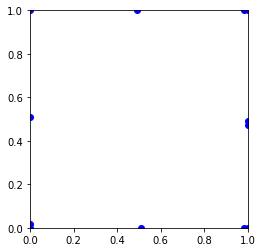

Param is 75
Time elapsed: 1.5294339656829834 sec
average relative error of u: 5.380974556450519%
maximum relative error of u: 7.3690668490837234%

Param is 76
Time elapsed: 1.2889375686645508 sec
average relative error of u: 5.299443510015486%
maximum relative error of u: 7.2615547493372805%

Param is 77
Time elapsed: 1.4214909076690674 sec
average relative error of u: 5.21829618948969%
maximum relative error of u: 7.155001247861481%

Param is 78
Time elapsed: 1.0762255191802979 sec
average relative error of u: 5.137629898803172%
maximum relative error of u: 7.049411280811619%

Param is 79
Time elapsed: 1.179569959640503 sec
average relative error of u: 5.057575408277264%
maximum relative error of u: 6.945088195128586%

Param is 80
Time elapsed: 4.189479112625122 sec
average relative error of u: 4.978222989362204%
maximum relative error of u: 6.8428814535257%

Param is 81
Time elapsed: 3.653454303741455 sec
average relative error of u: 4.899626826566415%
maximum relative error of u: 6.

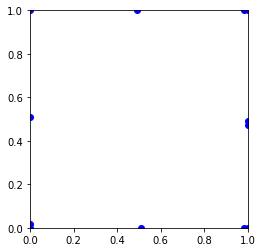

Param is 75
Time elapsed: 1.9105861186981201 sec
average relative error of u: 4.604183208790234%
maximum relative error of u: 8.15970343134229%

Param is 76
Time elapsed: 1.858567714691162 sec
average relative error of u: 4.544730476999658%
maximum relative error of u: 8.050138358867029%

Param is 77
Time elapsed: 1.327807903289795 sec
average relative error of u: 4.485279123792241%
maximum relative error of u: 7.941328119684544%

Param is 78
Time elapsed: 8.298875093460083 sec
average relative error of u: 4.425794803738404%
maximum relative error of u: 7.830991206734502%

Param is 79
Time elapsed: 1.179105520248413 sec
average relative error of u: 4.366513978531299%
maximum relative error of u: 7.721599215747786%

Param is 80
Time elapsed: 3.3786208629608154 sec
average relative error of u: 4.307518619498203%
maximum relative error of u: 7.614143561125858%

Param is 81
Time elapsed: 1.1969444751739502 sec
average relative error of u: 4.2487288272661905%
maximum relative error of u: 7.

In [5]:
solution=np.zeros((len(num_basis),len(FOM_parameters),nt+1,nx*ny))
avg_rel_err=np.zeros((len(num_basis),len(FOM_parameters)))
rel_err=np.zeros((len(num_basis),len(FOM_parameters),nt+1))
elapsed_time=np.zeros((len(num_basis),len(FOM_parameters)))

with open(file=file_name_SVD, mode='rb') as ff:  
    SVD = pickle.load(ff)

for ii in range(len(num_basis)):
    POD_basis=num_basis[ii]
    print("# of POD basis is {}".format(POD_basis))
    
    # DEIM
    num_msmt=12
    U = SVD['U'];S = SVD['S']

    phi_DEIM=U[:,:POD_basis]

    msmt_idx=DEIM(phi_DEIM,num_msmt,inner_raveled_indicies)
    msmt_idx.sort()

    print("# of measurments: {}".format(len(msmt_idx)))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(x[msmt_idx],y[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
    plt.show()

    # Basis matrix
    phi_u = SVD['U'][:,:POD_basis]

    phim_u=phi_u[msmt_idx]
    phim_u_pinv=np.linalg.pinv(phim_u)
    
    for jj in range(len(FOM_parameters)):
        FOM_parameter=FOM_parameters[jj]
        print("Param is {}".format(FOM_parameter))
        
        # Load FOM solution
        ex = np.load('./wave_data/ex23_interp_{}.npz'.format(FOM_parameter), allow_pickle = True)
        ex = ex.f.arr_0
        u_full = ex.reshape(nt+1,-1)

        # take measurments
        um = u_full[:,msmt_idx]

        # Initial condition
        u0=u_full[0]
        u_ref = u0

        # Gappy POD
        t_start_gappyPOD=time.time()

        # solution
        u_gappyPOD=np.zeros((nt+1,ny*nx))
        u_hat=np.zeros((nt+1,POD_basis))

        # IC
        u_hat0=np.zeros(POD_basis)
        u_gappyPOD[0]=np.copy(u0)

        for n in range(nt):
            u_hat[n+1] = phim_u_pinv.dot(um[n+1]-u_ref[msmt_idx])
            u_gappyPOD[n+1] = u_ref + phi_u.dot(u_hat[n+1])

        # elapsed time
        t_elapsed_gappyPOD=time.time()-t_start_gappyPOD
        print('Time elapsed: {} sec'.format(t_elapsed_gappyPOD))

        # error
        u_rel_err_gappyPOD=np.linalg.norm(u_full-u_gappyPOD,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
        u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_gappyPOD,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
        print("average relative error of u: {}%".format(u_avg_rel_err))
        print("maximum relative error of u: {}%".format(np.max(u_rel_err_gappyPOD)))
        print()

        # save result
        solution[ii,jj]=u_gappyPOD
        avg_rel_err[ii,jj]=u_avg_rel_err
        rel_err[ii,jj]=u_rel_err_gappyPOD
        elapsed_time[ii,jj]=t_elapsed_gappyPOD
    
results={'solution':solution,'avg_rel_err':avg_rel_err,'rel_err':rel_err,'elapsed_time':elapsed_time}
with open(file=file_path_gappy_DEIM_result, mode='wb') as ff:
    pickle.dump(results, ff)

In [6]:
print(num_basis)
idx=[0,1,2,3]
num_basis[idx]

[3 4 5 6]


array([3, 4, 5, 6])

Text(0.5, 1.0, 'Max. Rel. Err. vs Parameters')

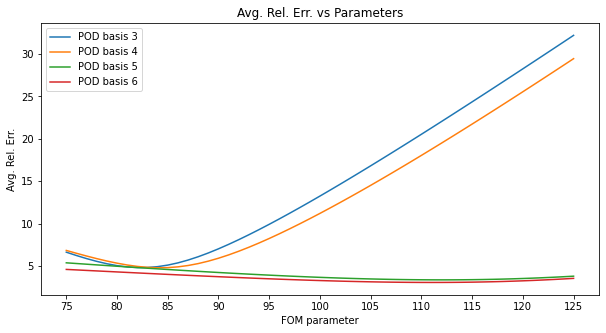

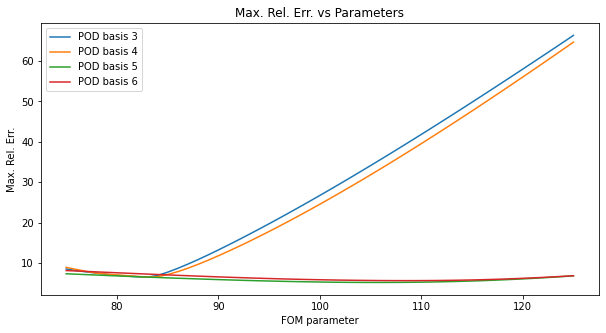

In [7]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:   
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])

ax=plt.gca()
ax.xaxis.set_major_locator(IndexLocator(p_inter,0))
ax.xaxis.set_minor_locator(IndexLocator(p_inter,p_inter))
ax.tick_params(axis='x',which='minor',labelcolor='blue',labelsize=20)
plt.title('Avg. Rel. Err. vs Parameters')
# plt.savefig("./wave_result/ex23_POD_bndry_DEIM_avg_rel_err.png")

# figure rel.err vs data points
plt.figure(figsize=(10,5))
plt_inter=1
for i in idx:   
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])
plt.title('Max. Rel. Err. vs Parameters')
# plt.savefig("./wave_result/ex23_POD_bndry_DEIM_max_rel_err.png")

In [8]:
print(num_basis)
print(FOM_parameters)

[3 4 5 6]
[ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]


In [9]:
idx=[3]
num_basis[idx]

array([6])

Text(0.5, 1.0, 'Max. Rel. Err. vs Parameters')

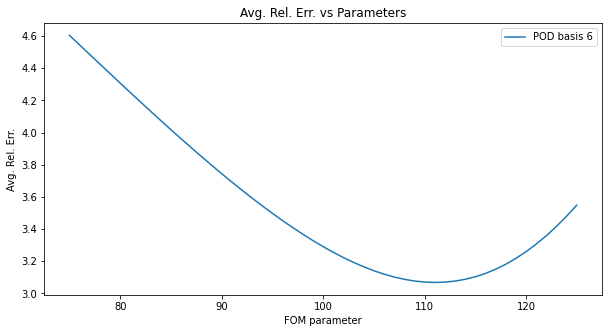

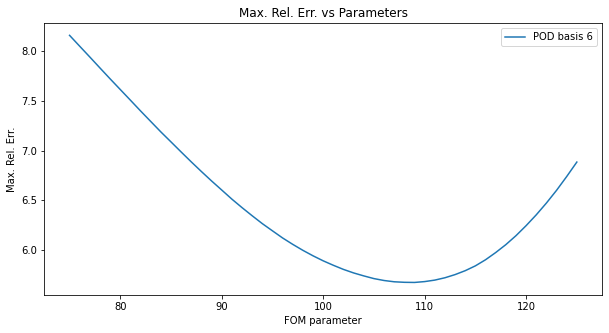

In [10]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:   
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])
plt.title('Avg. Rel. Err. vs Parameters')
# plt.savefig("./wave_result/ex23_POD_{}_bndry_DEIM_avg_rel_err.png".format(int(num_basis[idx])))

# figure rel.err vs data points
plt.figure(figsize=(10,5))
plt_inter=1
for i in idx:   
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["POD basis "+str(POD_basis) for POD_basis in num_basis[idx]])
plt.title('Max. Rel. Err. vs Parameters')
# plt.savefig("./wave_result/ex23_POD_{}_bndry_DEIM_max_rel_err.png".format(int(num_basis[idx])))

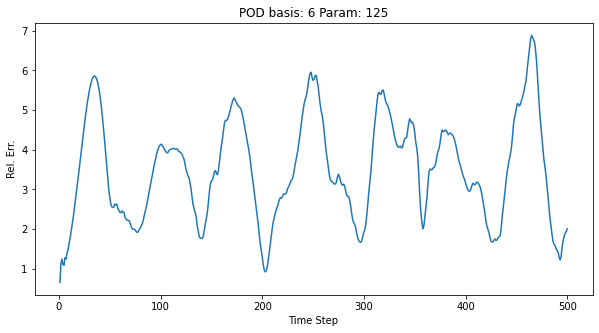

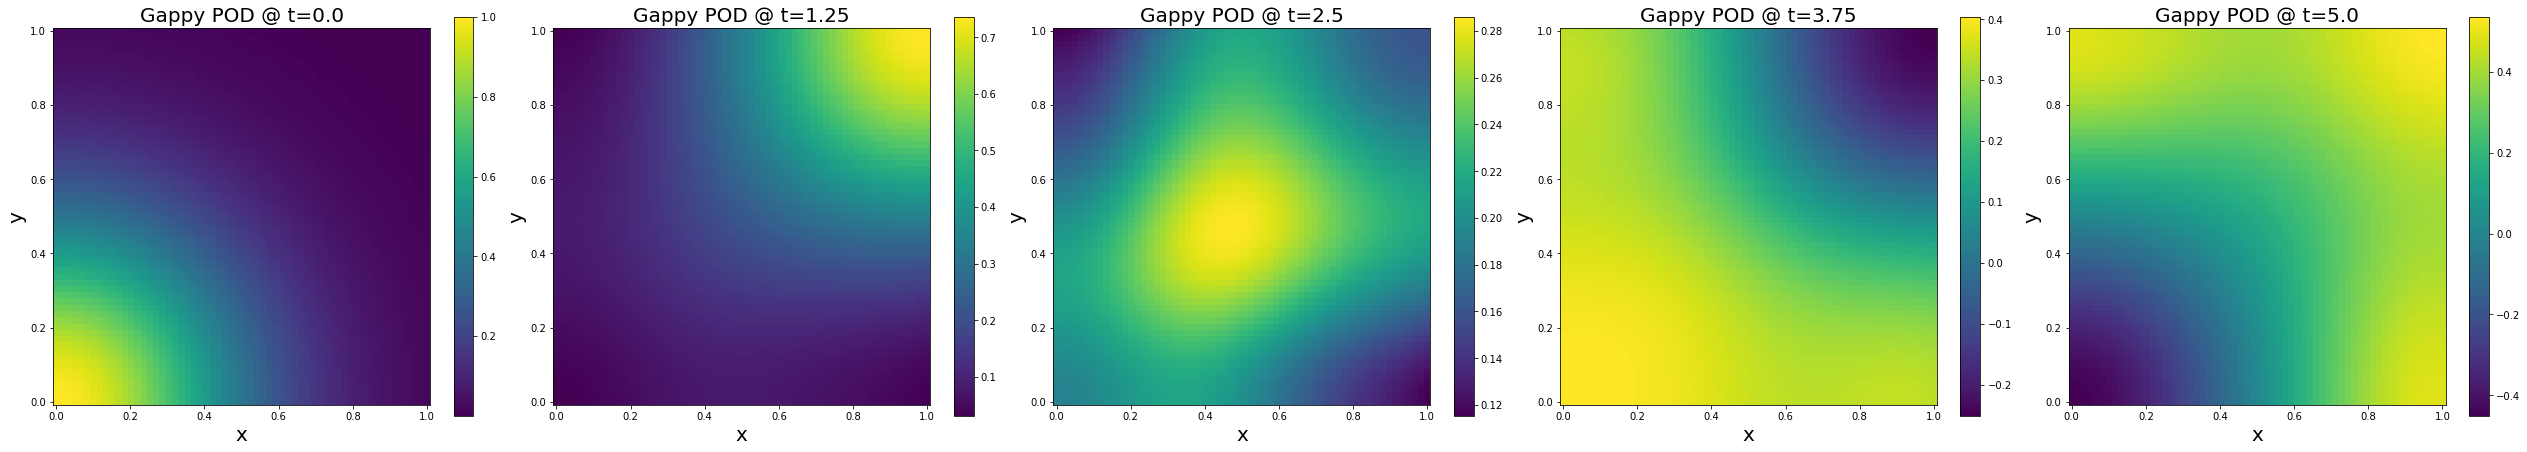

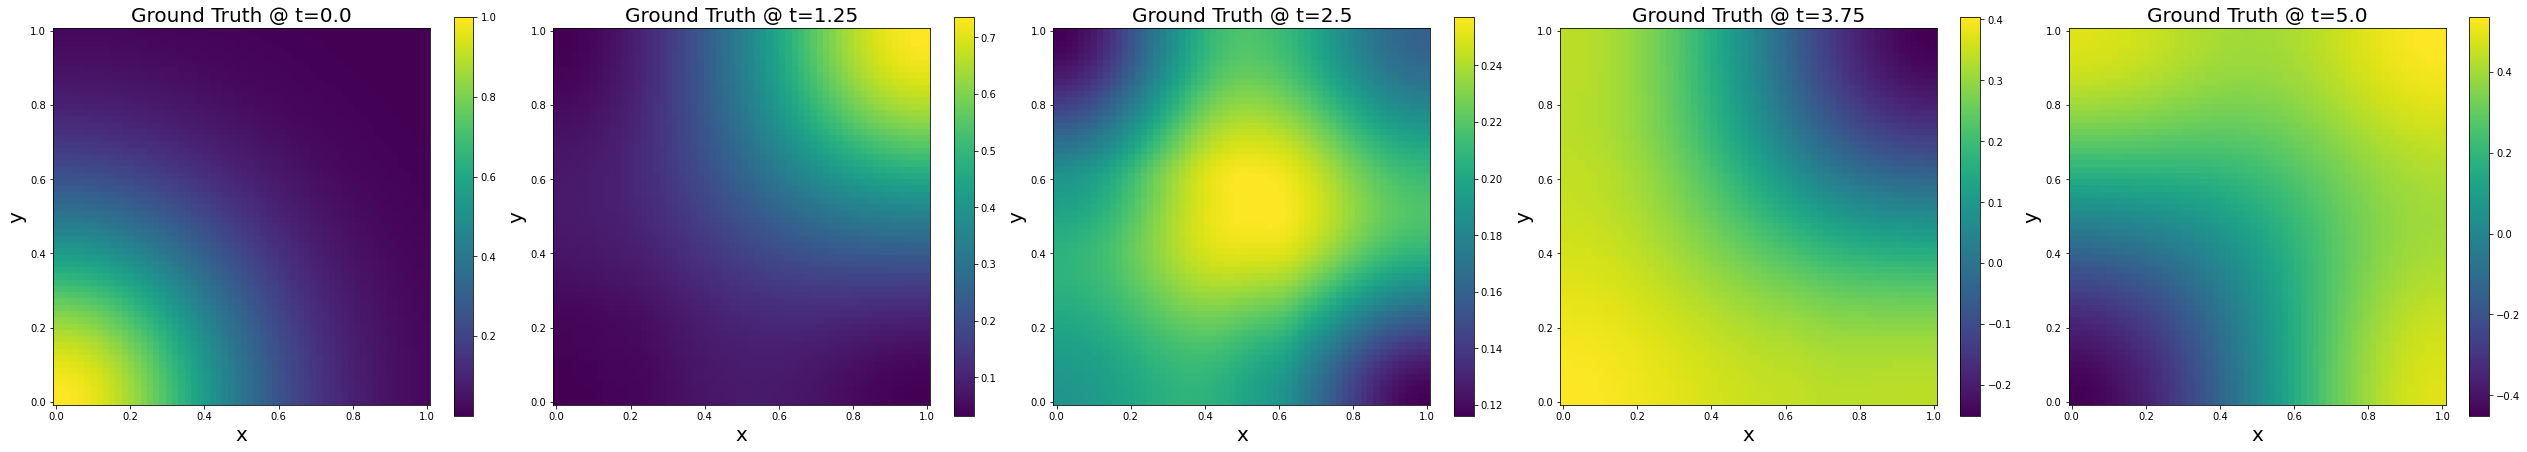

In [11]:
# figure rel.err vs at given param and POD basis
i=3;j=-1
POD_basis=num_basis[i]                 
param=FOM_parameters[j]

u_gappyPOD=results['solution'][i,j]

ex = np.load('./wave_data/ex23_interp_{}.npz'.format(param), allow_pickle = True)
ex = ex.f.arr_0
u_full = ex.reshape(nt+1,-1)

plt.figure(figsize=(10,5))
plt.plot(np.arange(1,nt+1),results['rel_err'][i,j,1:].flatten())
plt.xlabel('Time Step')
plt.ylabel('Rel. Err.')
plt.title("POD basis: {} Param: {}".format(POD_basis,param))
plt.show()

# plot original data
vmin=-1; vmax=1
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyPOD[int(nt/4)*i].reshape(ny,nx))#,vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Gappy POD @ t={}'.format(int(nt/4)*i*dt),fontsize=20)
    fig.colorbar(pcm, ax=ax,shrink=0.8)

# fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("./wave_result/ex23_POD_{}_param_{}_bndry_DEIM_SOL.png".format(POD_basis,param))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[int(nt/4)*i].reshape(ny,nx))#,vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Ground Truth @ t={}'.format(int(nt/4)*i*dt),fontsize=20)
    fig.colorbar(pcm, ax=ax,shrink=0.8)

# fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("./wave_result/ex23_param_{}_ground_truth.png".format(param))